In [ ]:
import numpy as np
from scipy import sparse
from scipy.special import digamma, gammaln
from scipy.stats import beta # for beta distribution
import gensim.corpora as corpora # for dictionary
from gensim.models.coherencemodel import CoherenceModel # for coherence calculation
from typing import List, Dict
import logging
import time

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [ ]:
# Hyperparameters
L = 3  # Tree depth
K = 3  # Branching factor
gamma = 1.0  # nCRP parameter (controls path diversity)
eta = 0.1  # Topic Dirichlet parameter (beta in PDF)
m = 1.0  # GEM scale
pi = np.ones(L) / L  # Uniform level prior
max_iter = 50  # Max iterations
tol = 1e-3  # Convergence threshold


In [4]:
def load_ap_data(ap_data: str, ap_vocab: str) -> sparse.csr_matrix:
    n = len(open(ap_data).readlines())
    m = len(open(ap_vocab).readlines())
    X = sparse.lil_matrix((n, m))
    for i, line in enumerate(open(ap_data)):
        words = line.split()
        idxs = []
        vals = []
        for w in words[1:]:
            idx, val = map(int, w.split(':'))
            idxs.append(idx)
            vals.append(val)
        X[i, idxs] = vals
    return X.tocsr()

In [6]:
# Load data
X = load_ap_data('../ap/ap.dat', '../ap/vocab.txt')
D, V = X.shape
logging.info(f"Loaded dataset: {D} documents, {V} vocabulary size")

2025-06-15 11:25:01,156 - INFO - Loaded dataset: 2246 documents, 10473 vocabulary size


In [7]:
# Document lengths
N_d = np.array(X.sum(axis=1)).flatten()

In [10]:
# Vocabulary
with open('../ap/vocab.txt', 'r') as f:
    vocab = [line.strip() for line in f]
logging.info(f"Loaded vocabulary with {len(vocab)} words")


2025-06-15 11:26:29,807 - INFO - Loaded vocabulary with 10473 words


Create Topic Tree 

.Purpose: Build nCRP tree with stick-breaking weights (PDF Section 1).

.Formula: v_n,ℓ ~ Beta(1, γ), π_n,ℓ,k = v_n,ℓ,k * ∏_{j=1}^{k-1} (1 - v_n,ℓ,j)

.Optimizations: Limit to L-1 levels, precompute node indices.

In [ ]:
num_nodes = int((K ** L - 1) / (K - 1))  # Internal nodes
nodes_per_level = [K**l for l in range(L)]  # [1, K, K^2, ...]

children: Dict[int, List[int]] = {} # Children of each node
stick_weights: Dict[int, np.ndarray] = {} # store pi values for each node
parent_map: Dict[int, int] = {} # Parent of each node
node_id = 0 # Initialize node ID

for level in range(L - 1):
    nodes_at_level = list(range(sum(nodes_per_level[:level]), sum(nodes_per_level[:level + 1]))) # Nodes at current level 
    for n in nodes_at_level:
        children[n] = [] 
        v_nlk = beta.rvs(1, gamma, size=K)  # Sample random stick-breaking proportions
        pi_nlk = np.zeros(K) 
        remaining = 1.0
        for k in range(K):
            pi_nlk[k] = v_nlk[k] * remaining
            remaining *= (1 - v_nlk[k])
            children[n].append(node_id + 1)
            parent_map[node_id + 1] = n
            node_id += 1
        stick_weights[n] = pi_nlk / np.sum(pi_nlk)
logging.info(f"Created tree with {num_nodes} nodes, {len(children)} internal nodes")

2025-06-15 11:28:17,298 - INFO - Created tree with 13 nodes, 4 internal nodes


Initialize Variational Parameters

In [ ]:
# Purpose: Set up q(c_d), q(θ_d), q(z_di), q(φ_t) (PDF Section 3).
# Optimizations: Sparse phi_di, stable Dirichlet initialization.
max_nodes_per_level = max(nodes_per_level)
q_c = np.zeros((D, L, max_nodes_per_level)) # q_c[d, l, t] = proba que le document d choisisse le nœud t au niveau l.
for d in range(D):
    for l in range(L):
        q_c[d, l, :nodes_per_level[l]] = np.random.dirichlet(np.ones(nodes_per_level[l]) * 0.1 ) # will store the probability that document d selects node t at level l. 0.1 is used for sparsity
alpha_d = np.ones((D, L)) * 0.1
lambda_t = np.ones((num_nodes, V)) * eta

phi_di = []
for d in range(D):
    word_indices = X[d].nonzero()[1]
    word_counts = X[d].data
    phi_d = np.zeros((int(N_d[d]), L))
    pos = 0
    for idx, count in zip(word_indices, word_counts):
        for _ in range(int(count)):
            phi_d[pos] = np.random.dirichlet(np.ones(L) * 0.1)
            pos += 1
    phi_di.append(phi_d)
logging.info("Initialized variational parameters")


2025-06-15 11:40:11,872 - INFO - Initialized variational parameters


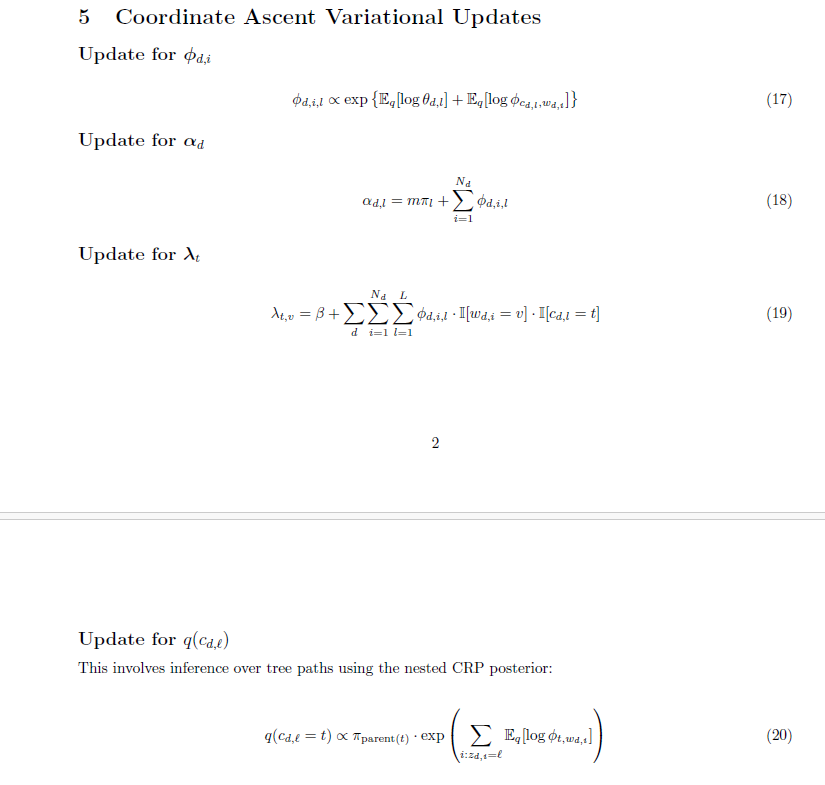

Coordinate Ascent Variational Inference

In [ ]:
elbo_history = []
start_time = time.time()

for iteration in range(max_iter):
    # Update phi_di 
    # --- Update φ_di (variational level assignments for each word token) ---
    # For each word token w_{d,i} in document d, compute the variational distribution φ_{d,i}^{(l)} over levels l.
    # This is a softmax over the sum of:
    #   - E_q[log θ_{d,l}] = digamma(α_{d,l}) - digamma(sum_l' α_{d,l'})
    #   - E_q[log φ_{t(l)}(w_{d,i})] = digamma(λ_{t,w}) - digamma(sum_v λ_{t,v})
    # Here:
    #   - λ_t is the topic (word distribution) at node t
    #   - t(l) is the selected node at level l, computed as t = argmax(q_c[d, l, :])
    #   - The softmax ensures φ_{d,i} is a valid probability distribution over levels.
    # φ_{d,i} is normalized after subtracting max for numerical stability.

    for d in range(D):
        log_theta = digamma(alpha_d[d]) - digamma(np.sum(alpha_d[d]))
        word_indices = X[d].nonzero()[1]
        word_counts = X[d].data
        pos = 0
        for idx, count in zip(word_indices, word_counts):
            for _ in range(int(count)):
                log_phi = np.zeros(L)
                for l in range(L):
                    t_local = np.argmax(q_c[d, l, :nodes_per_level[l]])
                    t_global = t_local + sum(nodes_per_level[:l])
                    log_phi[l] = digamma(lambda_t[t_global, idx]) - digamma(np.sum(lambda_t[t_global]))
                phi_di[d][pos] = np.exp(log_theta + log_phi - np.max(log_theta + log_phi))
                phi_di[d][pos] /= np.sum(phi_di[d][pos]) + 1e-10
                pos += 1

    # Update alpha_d
    alpha_d = m * pi + np.array([np.sum(phi_d, axis=0) for phi_d in phi_di])

    # Update lambda_t
    lambda_t = np.ones((num_nodes, V)) * eta
    for d in range(D):
        word_indices = X[d].nonzero()[1]
        word_counts = X[d].data
        pos = 0
        for idx, count in zip(word_indices, word_counts):
            for _ in range(int(count)):
                for l in range(L):
                    for t_local in range(nodes_per_level[l]):
                        t_global = t_local + sum(nodes_per_level[:l])
                        lambda_t[t_global, idx] += phi_di[d][pos, l] * q_c[d, l, t_local]
                pos += 1

    # Update q_c
    for d in range(D):
        word_indices = X[d].nonzero()[1]
        word_counts = X[d].data
        pos = 0
        word_pos = []
        for idx, count in zip(word_indices, word_counts):
            for _ in range(int(count)):
                word_pos.append((idx, pos))
                pos += 1
        for l in range(L):
            log_q = np.zeros(nodes_per_level[l])
            parent = 0 if l == 0 else (sum(nodes_per_level[:l-1]) + np.argmax(q_c[d, l-1, :nodes_per_level[l-1]]))
            weights = stick_weights.get(parent, np.ones(K) / K)[:nodes_per_level[l]]  # Fix: Limit weights to K
            for t_idx in range(nodes_per_level[l]):
                t_global = t_idx + sum(nodes_per_level[:l])
                log_phi_sum = 0
                for v, p in word_pos:
                    log_phi_sum += phi_di[d][p, l] * (digamma(lambda_t[t_global, v]) - digamma(np.sum(lambda_t[t_global])))
                log_q[t_idx] = np.log(weights[t_idx % K] + 1e-10) + log_phi_sum  # Fix: Use modulo K
            log_q -= np.max(log_q)
            q_c[d, l, :nodes_per_level[l]] = np.exp(log_q)
            q_c[d, l, :nodes_per_level[l]] /= np.sum(q_c[d, l, :nodes_per_level[l]]) + 1e-10

    # Compute ELBO (PDF Section 4)
    elbo = 0
    # E[log p(φ_t)]
    for t in range(num_nodes):
        elbo += gammaln(V * eta) - V * gammaln(eta) + np.sum((eta - 1) * (digamma(lambda_t[t]) - digamma(np.sum(lambda_t[t]))))
    # E[log p(θ_d)]
    for d in range(D):
        elbo += gammaln(np.sum(m * pi)) - np.sum(gammaln(m * pi)) + np.sum((m * pi - 1) * (digamma(alpha_d[d]) - digamma(np.sum(alpha_d[d]))))
    # E[log p(z_di | θ_d)]
    for d in range(D):
        log_theta = digamma(alpha_d[d]) - digamma(np.sum(alpha_d[d]))
        elbo += np.sum(phi_di[d] * log_theta)
    # E[log p(w_di | z_di, φ_c_d,z_di)]
    for d in range(D):
        word_indices = X[d].nonzero()[1]
        word_counts = X[d].data
        pos = 0
        for idx, count in zip(word_indices, word_counts):
            for _ in range(int(count)):
                for l in range(L):
                    t_local = np.argmax(q_c[d, l, :nodes_per_level[l]])
                    t_global = t_local + sum(nodes_per_level[:l])
                    elbo += phi_di[d][pos, l] * (digamma(lambda_t[t_global, idx]) - digamma(np.sum(lambda_t[t_global])))
                pos += 1
    # -E[log q(θ_d)]
    for d in range(D):
        elbo -= (gammaln(np.sum(alpha_d[d])) - np.sum(gammaln(alpha_d[d])) + np.sum((alpha_d[d] - 1) * (digamma(alpha_d[d]) - digamma(np.sum(alpha_d[d])))))
    # -E[log q(z_di)]
    for d in range(D):
        elbo -= np.sum(phi_di[d] * np.log(phi_di[d] + 1e-10))
    # -E[log q(φ_t)]
    for t in range(num_nodes):
        elbo -= (gammaln(np.sum(lambda_t[t])) - np.sum(gammaln(lambda_t[t])) + np.sum((lambda_t[t] - 1) * (digamma(lambda_t[t]) - digamma(np.sum(lambda_t[t])))))
    # -E[log q(c_d)]
    for d in range(D):
        for l in range(L):
            elbo -= np.sum(q_c[d, l, :nodes_per_level[l]] * np.log(q_c[d, l, :nodes_per_level[l]] + 1e-10))
    
    elbo_history.append(elbo)
    logging.info(f"Iteration {iteration + 1}, ELBO: {elbo:.2f}, Time: {time.time() - start_time:.2f}s")

    # Check convergence
    if len(elbo_history) > 1:
        if elbo_history[-1] < elbo_history[-2]:
            logging.warning(f"ELBO decreased from {elbo_history[-2]:.2f} to {elbo_history[-1]:.2f}")
        if abs(elbo_history[-1] - elbo_history[-2]) < tol:
            logging.info(f"Converged at iteration {iteration + 1}")
            break

2025-06-15 11:43:09,306 - INFO - Iteration 1, ELBO: -3843355.67, Time: 92.51s
2025-06-15 11:44:40,514 - INFO - Iteration 2, ELBO: -3795513.66, Time: 183.72s
2025-06-15 11:46:06,667 - INFO - Iteration 3, ELBO: -3760512.73, Time: 269.87s
2025-06-15 11:47:45,755 - INFO - Iteration 4, ELBO: -3737286.37, Time: 368.96s
2025-06-15 11:49:36,563 - INFO - Iteration 5, ELBO: -3721096.73, Time: 479.77s
2025-06-15 11:51:30,731 - INFO - Iteration 6, ELBO: -3708724.45, Time: 593.94s
2025-06-15 11:53:54,230 - INFO - Iteration 7, ELBO: -3698604.31, Time: 737.44s
2025-06-15 11:56:13,617 - INFO - Iteration 8, ELBO: -3689955.06, Time: 876.82s
2025-06-15 11:59:11,756 - INFO - Iteration 9, ELBO: -3682461.22, Time: 1054.96s
2025-06-15 12:02:20,810 - INFO - Iteration 10, ELBO: -3676000.60, Time: 1244.02s
2025-06-15 12:05:36,911 - INFO - Iteration 11, ELBO: -3670511.56, Time: 1440.12s
2025-06-15 12:08:47,667 - INFO - Iteration 12, ELBO: -3665829.42, Time: 1630.87s
2025-06-15 12:11:02,624 - INFO - Iteration 13,

Print Topics, Paths, and Levels

In [16]:
# Purpose: Extract interpretable results (PDF Sections 2, 3).
# Optimizations: Limit to top 10 words, first 5 documents.
for t in range(num_nodes):
    top_indices = np.argsort(lambda_t[t])[::-1][:10]
    top_words = [vocab[i] for i in top_indices]
    logging.info(f"Topic {t}: {' '.join(top_words)}")

for d in range(min(5, D)):
    path = [sum(nodes_per_level[:l]) + np.argmax(q_c[d, l, :nodes_per_level[l]]) for l in range(L)]
    level_props = alpha_d[d] / np.sum(alpha_d[d])
    logging.info(f"Document {d} path: {path}, level proportions: {level_props}")

2025-06-15 13:33:09,563 - INFO - Topic 0: i people president government years two new state soviet police
2025-06-15 13:33:09,566 - INFO - Topic 1: percent million year two market new police people government today
2025-06-15 13:33:09,568 - INFO - Topic 2: bush dukakis i new percent campaign jackson president republican democratic
2025-06-15 13:33:09,570 - INFO - Topic 3: i two southern miles year people new like first time
2025-06-15 13:33:09,574 - INFO - Topic 4: dollar late yen new percent prices bid gold london bank
2025-06-15 13:33:09,575 - INFO - Topic 5: new company billion trade states children york agreement business department
2025-06-15 13:33:09,577 - INFO - Topic 6: million oil new cbs percent network last year news week
2025-06-15 13:33:09,579 - INFO - Topic 7: east west german oil new united york states israel million
2025-06-15 13:33:09,581 - INFO - Topic 8: company court million soviet years death eastern demjanjuk judge contract
2025-06-15 13:33:09,582 - INFO - Topic 9

Evaluate Model

In [ ]:
# Purpose: Compute perplexity and UMass coherence (PDF Section 4).
# Perplexity — a measure of how well the model predicts the data.
# UMass Coherence — a measure of how interpretable the topics are, based on word co-occurrence
# Optimizations: Reuse ELBO word likelihood, efficient gensim processing.
log_likelihood = 0
total_words = np.sum(N_d)
for d in range(D):
    word_indices = X[d].nonzero()[1]
    word_counts = X[d].data
    pos = 0
    for idx, count in zip(word_indices, word_counts):
        for _ in range(int(count)):
            log_p_w = 0
            for l in range(L):
                t_local = np.argmax(q_c[d, l, :nodes_per_level[l]])
                t_global = t_local + sum(nodes_per_level[:l])
                log_p_w += phi_di[d][pos, l] * (digamma(lambda_t[t_global, idx]) - digamma(np.sum(lambda_t[t_global])))
            log_likelihood += log_p_w
            pos += 1
perplexity = np.exp(-log_likelihood / total_words)
logging.info(f"Perplexity: {perplexity:.2f}")

texts = [[vocab[idx] for idx, count in zip(X[d].nonzero()[1], X[d].data) for _ in range(int(count))] for d in range(D)]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
topics = [[vocab[i] for i in np.argsort(lambda_t[t])[::-1][:20]] for t in range(num_nodes)]
cm = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='u_mass')
coherence = cm.get_coherence()
logging.info(f"UMass Coherence: {coherence:.2f}")

2025-06-15 13:33:44,275 - INFO - Perplexity: 2344.21
2025-06-15 13:33:44,689 - INFO - adding document #0 to Dictionary<0 unique tokens: []>
2025-06-15 13:33:44,941 - INFO - built Dictionary<10473 unique tokens: ['adding', 'adult', 'ago', 'alcohol', 'allegedly']...> from 2246 documents (total 435838 corpus positions)
2025-06-15 13:33:44,952 - INFO - Dictionary lifecycle event {'msg': "built Dictionary<10473 unique tokens: ['adding', 'adult', 'ago', 'alcohol', 'allegedly']...> from 2246 documents (total 435838 corpus positions)", 'datetime': '2025-06-15T13:33:44.948055', 'gensim': '4.3.3', 'python': '3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'created'}
2025-06-15 13:33:45,335 - INFO - CorpusAccumulator accumulated stats from 1000 documents
2025-06-15 13:33:45,354 - INFO - CorpusAccumulator accumulated stats from 2000 documents
2025-06-15 13:33:45,390 - INFO - UMass Coherence: -2.43


Visualize ELBO

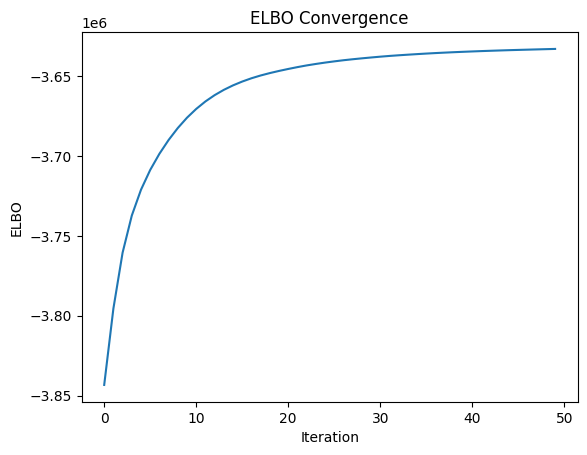

In [18]:
# Purpose: Plot ELBO to confirm convergence (PDF Section 4).
# Note: Run in Jupyter to see the plot.
import matplotlib.pyplot as plt
plt.plot(elbo_history)
plt.xlabel('Iteration')
plt.ylabel('ELBO')
plt.title('ELBO Convergence')
plt.show()